<a href="https://colab.research.google.com/github/TheMrGhostman/Deep_Q-Learning_Cartpole/blob/master/DQN_in_keras_optimalizace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
""" Kdyby nebyla nějaká knihovna nainstalovaná tak spustit tohle"""
!pip install gym
!pip install numpy
!pip install matplotlib
!pip install tensorflow-gpu

In [1]:
import os
import gym
import copy
import random
import time as tm
import numpy as np
import tensorflow as tf
from collections import deque
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from matplotlib import pyplot as plt
print("Gym:", gym.__version__)
print("Tensorflow:", tf.__version__)

Gym: 0.10.11
Tensorflow: 1.13.1


Using TensorFlow backend.


In [34]:
# načtení uložených modelů k tomuto notebooku
!git clone https://github.com/TheMrGhostman/Deep_Q-Learning_Cartpole

Cloning into 'Deep_Q-Learning_Cartpole'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 55 (delta 50), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (55/55), done.


In [0]:
os.chdir("Deep_Q-Learning_Cartpole/src")

# Deep Q-Learning Agent (Network)
![alt text](https://cdn-images-1.medium.com/max/600/1*0_TNa54fr_LsLOllgIsrcw.png)

In [0]:
class DQNAgent:
    def __init__(self, state_size, action_size, first_layer=24, second_layer=24):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)     # Buffer
        self.gamma = 0.95                    # discount rate
        self.epsilon = 1.0                   # zvědavost     
        self.epsilon_min = 0.01              # min zvědavost
        self.epsilon_decay = 0.999           # jak moc rychle se má zmenšovat zvědavost
        self.learning_rate = 0.01
        self.num_neurons_first_layer = first_layer    # 24
        self.num_neurons_second_layer = second_layer   # 24
        self.model = self._build_model()

        
    def _info(self, plus=False):
        info = "learning_rate={}_minEps={}_gamma={}"\
        .format(self.learning_rate, self.epsilon_min, self.gamma)
        if plus:
            info = info + "_FirstL:{}_SecondL:{}"\
            .format(self.num_neurons_first_layer, self.num_neurons_second_layer)
        return info
    
    
    def _build_model(self):
        """
            Deep Q Neural Network  
        """
        model = Sequential()
        model.add(Dense(self.num_neurons_first_layer, input_dim=self.state_size, activation='relu'))
        model.add(Dense(self.num_neurons_second_layer, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    
    def remember(self, state, action, reward, next_state, done):
        """
            Buffer k zapamatování historie resp. scénářů 
        """
        self.memory.append((state, action, reward, next_state, done))

        
    def act(self, state):
        """
            Na začátku, když není síť trénovaná mohla by se už na začátku zacyklit
            ve špatných rozhodnutích. Proto je na začátku důležité dělat 
            rozhodnutí o akcích náhodně. Proto je tu přidaná možnost náhodného
            rozhodnutí, jejíž pravděpodobnost se s počtem episod zmenšuje. 
        """
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    
    def replay(self, batch_size):
        """
            Trénovací funkce, která přehrává a trénuje již provdené scénáře z Bufferu
        """
        
        minibatch = random.sample(self.memory, batch_size)
        """
        states, targets_f = [], []
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target 
            
            states.append(state[0])
            targets_f.append(target_f[0])
        history = self.model.fit(np.array(states), np.array(targets_f), epochs=1, verbose=0)
        """
        
        # provedl jsem menší optimalizaci tréninku => asi 10x rychlejší
        cur_states, actions, rewards, next_states, dones = [],[],[],[],[]
        for state, action, reward, next_state, done in minibatch:
            cur_states.append(state.tolist()[0])
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state.tolist()[0])
            dones.append(done)

        # Bellman Equation
        targets = rewards + self.gamma * np.amax(self.model.predict(np.array(next_states)),axis=1) * (1-np.array(dones))
        
        targets_f = self.model.predict(np.array(cur_states))
        targets_f[np.arange(len(actions)), actions] = targets
        history = self.model.fit(np.array(cur_states), np.array(targets_f), epochs=1, verbose=0)
        
        # Keeping track of loss
        loss = history.history['loss'][0]
        if self.epsilon > self.epsilon_min:   # decreasing exploration rate
            self.epsilon *= self.epsilon_decay
        return loss
    
    
    def load(self, name):
        self.model.load_model(name)

        
    def save(self, name):
        self.model.save(name)

# Training
- making enviroment 
- define agent
<br>
(Agent will be saved every 10 episodes.)
- training phase

In [0]:
''""" making enviroment """
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [6]:
""" Define Agetnt and properities"""

agent = DQNAgent(state_size, action_size, 24, 24)

# volitelné parametry agenta
agent.gamma = 0.9                    
agent.epsilon = 1.0                   
agent.epsilon_min = 0.01              
agent.epsilon_decay = 0.999           
agent.learning_rate = 0.01

# počet trénovacích vzorků pro fci replay
batch_size = 50 #100#32

print(vars(agent))
agent.model.summary()

{'state_size': 4, 'action_size': 2, 'memory': deque([], maxlen=5000), 'gamma': 0.9, 'epsilon': 1.0, 'epsilon_min': 0.01, 'epsilon_decay': 0.999, 'learning_rate': 0.01, 'num_neurons_first_layer': 24, 'num_neurons_second_layer': 24, 'model': <keras.engine.sequential.Sequential object at 0x7fa721875588>}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_8 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


In [8]:
EPISODES = 500
done = False

LOSS = []
SCORE = []
for e in range(EPISODES):
    
    """ zkoušel jsem jestli to trochu nevylepší skóre (E2 problém) """
    if e%100==0 and np.mean(SCORE[-10:]) < np.mean(SCORE):    
        agent.epsilon=0.3
    """"""    
        
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(500):
        # env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        
        #reward = reward if not done else -1   
        
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e+1, EPISODES, time+1, agent.epsilon))
            SCORE.append(time+1)
            break
        if len(agent.memory) > batch_size:
            loss = agent.replay(batch_size)
            LOSS.append(loss)
            
    if (e+1) % 10 == 0:
        agent.save(f"cartpole-dqn_{e}_{agent._info(True)}_fast.h5")

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode: 1/500, score: 17, e: 0.79
episode: 2/500, score: 120, e: 0.7
episode: 3/500, score: 53, e: 0.66
episode: 4/500, score: 28, e: 0.65
episode: 5/500, score: 12, e: 0.64
episode: 6/500, score: 39, e: 0.61
episode: 7/500, score: 20, e: 0.6
episode: 8/500, score: 67, e: 0.56
episode: 9/500, score: 19, e: 0.55
episode: 10/500, score: 112, e: 0.5
episode: 11/500, score: 52, e: 0.47
episode: 12/500, score: 259, e: 0.36
episode: 13/500, score: 64, e: 0.34
episode: 14/500, score: 100, e: 0.31
episode: 15/500, score: 205, e: 0.25
episode: 16/500, score: 265, e: 0.19
episode: 17/500, score: 500, e: 0.12
episode: 18/500, score: 250, e: 0.092
episode: 19/500, score: 414, e: 0.061
episode: 20/500, score: 370, e: 0.042
episode: 21/500, score: 310, e: 0.031
episode: 22/500, score: 319, e: 0.022
episode: 23/500, score: 275, e: 0.017
episode: 24/500, score: 342, e: 0.012
episode: 25/500, score: 286, e: 0.01
episode: 26/500, score: 430, e: 0.01
episode: 27/500, score: 465, e: 0.01
episode: 28/500,

## Loss and Score from training

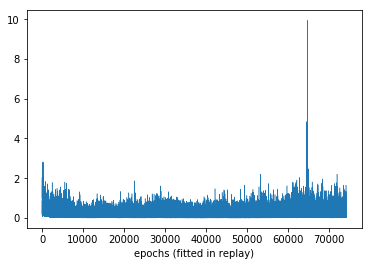

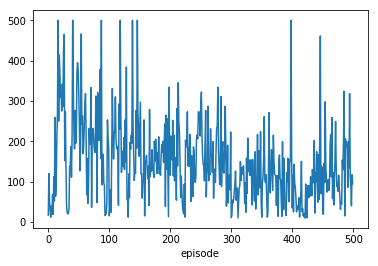

In [14]:
plt.figure("Loss after episode")
plt.plot(LOSS, lw=0.5)
plt.xlabel("epochs (fitted in replay)")
plt.show()
plt.figure("score in episodes")
plt.plot(SCORE)
plt.xlabel("episode")
plt.show()

In [11]:
np.mean(SCORE[:300])

177.94666666666666

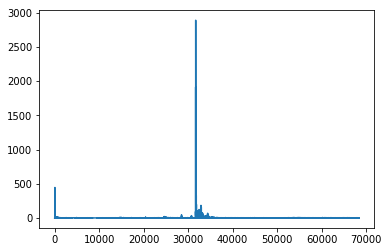

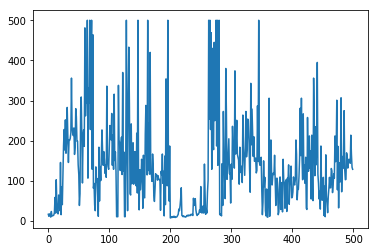

In [0]:
# ukázka staršího tréniku 
plt.figure("Loss after episode")
plt.plot(LOSS)
plt.show()
plt.figure("score in episodes")
plt.plot(SCORE)
plt.show()

In [0]:
np.save(f"score_per_episode_{agent._info()}.npy", np.array(SCORE))

# Model testing and evaluation

In [0]:
def Model_testing(env, Agent, episodes, eps, disp=True): 
    TOT_REW = []
    for i in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        state = state.reshape(1,state_size)
        time = 0
        tmp_eps = Agent.epsilon
        Agent.epsilon = eps
        while not done:
            time += 1
            action = Agent.act(state)
            next_state, reward, done, info = env.step(action)
            #env.render()                                          # v colabu env.render() nefunguje
            next_state = next_state.reshape(1, state_size)
            total_reward += reward
            state = next_state
        TOT_REW.append(total_reward)
        if disp:
            print(f"Game ({i+1}.) with reward {total_reward}")
        Agent.epsilon = tmp_eps
    print("Mean game reward for {} episodes is {}". format(episodes, np.mean(TOT_REW)))

In [28]:
Agent = DQNAgent(state_size, action_size, 32, 24)
Agent.model = keras.models.load_model("cartpole-dqn_19_learning_rate=0.01_minEps=0.01_gamma=0.9_FirstL:24_SecondL:24_fast.h5")
#"cartpole-dqn_489_learning_rate=0.01_minEps=0.01_gamma=0.95_fast3.h5"

Model_testing(env, Agent, 10, 0.0)
Model_testing(env, Agent, 100, 0.0, False)

Game (1.) with reward 319.0
Game (2.) with reward 233.0
Game (3.) with reward 242.0
Game (4.) with reward 428.0
Game (5.) with reward 292.0
Game (6.) with reward 277.0
Game (7.) with reward 267.0
Game (8.) with reward 252.0
Game (9.) with reward 275.0
Game (10.) with reward 310.0
Mean game reward for 10 episodes is 289.5
Mean game reward for 100 episodes is 282.33


Průměrné skóre je větší než 200 ... hra je tedy podle podle pravidel vyřešena.

# The best model
 - tento model jsem natrénoval již dříve a zatím se mi ho nepodařilo překonat. :D 

In [30]:
Agent = DQNAgent(state_size, action_size, 24, 24)
Agent.model = keras.models.load_model("model_24x24.h5")

Model_testing(env, Agent, 10, 0.0)

Game (1.) with reward 500.0
Game (2.) with reward 500.0
Game (3.) with reward 500.0
Game (4.) with reward 500.0
Game (5.) with reward 500.0
Game (6.) with reward 500.0
Game (7.) with reward 500.0
Game (8.) with reward 500.0
Game (9.) with reward 500.0
Game (10.) with reward 500.0
Mean game reward for 10 episodes is 500.0


In [31]:
!zip -r /content/file.zip /content/*

  adding: content/cartpole-dqn_109_learning_rate=0.01_minEps=0.01_gamma=0.9_FirstL:24_SecondL:24_fast.h5 (deflated 74%)
  adding: content/cartpole-dqn_119_learning_rate=0.01_minEps=0.01_gamma=0.9_FirstL:24_SecondL:24_fast.h5 (deflated 74%)
  adding: content/cartpole-dqn_129_learning_rate=0.01_minEps=0.01_gamma=0.9_FirstL:24_SecondL:24_fast.h5 (deflated 74%)
  adding: content/cartpole-dqn_139_learning_rate=0.01_minEps=0.01_gamma=0.9_FirstL:24_SecondL:24_fast.h5 (deflated 75%)
  adding: content/cartpole-dqn_149_learning_rate=0.01_minEps=0.01_gamma=0.9_FirstL:24_SecondL:24_fast.h5 (deflated 75%)
  adding: content/cartpole-dqn_159_learning_rate=0.01_minEps=0.01_gamma=0.9_FirstL:24_SecondL:24_fast.h5 (deflated 75%)
  adding: content/cartpole-dqn_169_learning_rate=0.01_minEps=0.01_gamma=0.9_FirstL:24_SecondL:24_fast.h5 (deflated 75%)
  adding: content/cartpole-dqn_179_learning_rate=0.01_minEps=0.01_gamma=0.9_FirstL:24_SecondL:24_fast.h5 (deflated 76%)
  adding: content/cartpole-dqn_189_learn

In [0]:
from google.colab import files
files.download("file.zip")